In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob, os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, date, time
import time
from scipy import stats
# import carbon_utils
import PyCO2SYS as pyco2
from scipy import interpolate
from tabulate import tabulate
import re
import matplotlib.gridspec as gridspec
from io import StringIO  # for creating a string buffer to store the table

In [2]:
# glodap_offsets_filename = 'glodap_offsets_100km_1450_to_2000_100m_0.005dens_0.005spice_4.nc'
# glodap_offsets_filename = 'glodap_offsets_100km_2_to_50_50m_0.1dens_0.1spice_5.nc'
# read in a user-created text file to point to local directories to avoid having to change this every time 
# we update code
lines=[]
with open('path_file.txt') as f:
    lines = f.readlines()
    
count = 0
for line in lines:
    count += 1
    index = line.find("=")
    #print(f'line {count}: {line}')
    #print(index)
    #print(line[0:index])
    line = line.rstrip()
    if line[0:index].find("argo")>=0:
        argo_path=line[index+1:]
    elif line[0:index].find("liar")>=0:
        liar_dir=line[index+1:]
    elif line[0:index].find("matlab")>=0:
        matlab_dir=line[index+1:]
        
# Set the paths
output_dir = 'output/'
data_dir = 'data/'

# Check for a glodap_offsets_plots directory, create if it does not exist
offset_dir = output_dir + 'glodap_offset_plots/'
if not os.path.isdir(offset_dir):
    os.mkdir(offset_dir)
grouped_plot_dir = offset_dir + 'grouped_plots/'
if not os.path.isdir(grouped_plot_dir):
    os.mkdir(grouped_plot_dir)



In [3]:
def test_stat(y, iteration, verboseTF):
    std_dev = np.std(y)
    avg_y = np.mean(y)
    abs_val_minus_avg = abs(y - avg_y)
    max_of_deviations = max(abs_val_minus_avg)
    max_ind = np.argmax(abs_val_minus_avg)
    cal = max_of_deviations/ std_dev
    if verboseTF:
        print('Test {}'.format(iteration))
        print("Test Statistics Value(R{}) : {}".format(iteration,cal))
    return cal, max_ind

def calculate_critical_value(size, alpha, iteration, verboseTF):
    t_dist = stats.t.ppf(1 - alpha / (2 * size), size - 2)
    numerator = (size - 1) * np.sqrt(np.square(t_dist))
    denominator = np.sqrt(size) * np.sqrt(size - 2 + np.square(t_dist))
    critical_value = numerator / denominator
    if verboseTF:
        print("Critical Value(λ{}): {}".format(iteration, critical_value))
    return critical_value

def check_values(R, C, inp, max_index, iteration):
    if R > C:
        print('{} is an outlier. R{} > λ{}: {:.4f} > {:.4f} \n'.format(inp[max_index],iteration, iteration, R, C))
    else:
        print('{} is not an outlier. R{}> λ{}: {:.4f} > {:.4f} \n'.format(inp[max_index],iteration, iteration, R, C))




def ESD_Test(input_series, alpha, max_outliers, verboseTF, NoOutputTF):
    stats = []
    critical_vals = []
    tested_values = []
    max_i = 0
    for iterations in range(1, max_outliers + 1):
        stat, max_index = test_stat(input_series, iterations, verboseTF)
        critical = calculate_critical_value(len(input_series), alpha, iterations, verboseTF)
        if verboseTF:
            check_values(stat, critical, input_series, max_index, iterations)
        tested_values.append(input_series[max_index])
        input_series = np.delete(input_series, max_index)
        critical_vals.append(critical)
        stats.append(stat)
        if stat > critical:
            max_i = iterations
    if ~NoOutputTF:
        print('H0:  there are no outliers in the data')
        print('Ha:  there are up to 10 outliers in the data')
        print('')
        print('Significance level:  α = {}'.format(alpha))
        print('Critical region:  Reject H0 if Ri > critical value')
        print('Ri: Test statistic')
        print('λi: Critical Value')
        print(' ')
    df = pd.DataFrame({'i' :range(1, max_outliers + 1), 'Ri': stats, 'λi': critical_vals , 'Vals': tested_values})
    
    def highlight_max(x):
        if x.i == max_i:
            return ['background-color: yellow']*4
        else:
            return ['background-color: white']*4
    df.index = df.index + 1
    print('Number of outliers {}'.format(max_i))
    print(max_i)
    return  df.style.apply(highlight_max, axis = 1), max_i, tested_values

In [4]:
#list of DOXY_ADJUSTED SCIENTIFIC_CALIB_COMMENT substrings to group together for bias analysis

#no calibration bad data
bad_cal_list = ['Sensor issue','out of order','Bad data; not adjustable','Biofouling','unadjustable']

#no calibration, reason unspecified
no_cal_list = ['no adjustment','No QC','none','not applicable']

#blank cal
blank_cal = ['                ']

#air cal
# air_cal_list = ['DOXY_ADJUSTED corrected using co','SVU Foil','Partial pressure','Bittig',
#                 'Adjusted with SAGEO2 using co','Adjusted with SAGEO2 with in-air',
#                 'PPOX converted from DOXY','G determined from float measure']
air_cal_list = ['in air', 'in-air']
#no air cal
noair_cal_surf_list = ['World Ocean Atlas', 'woa', 'WOA', 'no in-air', 'no in air', 
                       'climatology','DOXY_QCs are modified during visual check',
                      'Takeshita']
# ['DOXY_ADJUSTED is computed from','DOXY_ADJUSTED is estimated from',
#                        'Adjustment done on PPOX_DOXY;Tem','Polynomial calibration','Adjustment via comparison of',
#                       'optode multi calibration','RT adjustment by comparison','adjusted with median',
#                       'Adjusted with annual WOA','Adjusted on WOA monthly','Adjusted PPOX at zero for',
#                       'G determined by surface']

noair_cal_subsurf_list = []
# ['1-point multiplicative corr']

noair_cal_funcofdoxy_list = []
# ['Percent saturation corrected as','DOXY_ADJUSTED computed using Ste',
#                         'Oxygen concentration corrected']

noair_cal_unspec_list = []
# ['DOXY_ADJUSTED corrected based','Adjust with WOA monthly','GAIN determined from WOA2013',
#                         'Adjusted with WOA climatology','Adjusted with SAGEO2 based on WO',
#                          'Adjusted with SAGEO2 on WOA','Adjusted with WOA 2018','Takeshita and all, 2013']

noair_cal_withdrift_list = []
# ['Adjustment done on PPOX_DOXY;Tem'] #this is incomplete

noair_cal_combined_list = noair_cal_surf_list+noair_cal_subsurf_list+noair_cal_funcofdoxy_list+noair_cal_unspec_list

In [5]:
# loop through various glodap_offset plots, calculating trimmed mean for different pressure levels and storing for comparison
glodap_offsets = []
glodap_offsets_filenames = ['glodap_offsets_100km_1_to_550_50m_0.05dens_0.05spice_6.nc', 'glodap_offsets_100km_400_to_2100_100m_0.005dens_0.005spice_6.nc']

for filename in glodap_offsets_filenames:
    ds = xr.load_dataset(output_dir+filename)
    glodap_offsets.append(ds)

In [48]:
# Loop through each dataset
# calculate DOX_ADJUSTED_offset_trimmed, using only data from a specific depth range 
pressure_levels = [0, 100, 200, 300, 400, 500, 750, 1000, 1250, 1500, 2000]  # Adjust as needed
# pressure_levels = [0, 100, 200]#, 300]#, 400, 500, 750, 1000, 1250, 1500, 2000]  # Adjust as needed

mean_gdap_offsets = {}

year_filt = 1
year_plus_minus = 5

for idx, gdap_offsets_n in enumerate(glodap_offsets):

    trimmed_means = {}
    # variables with offsets that you want to trim
    var_list_plot = ['PRES_ADJUSTED','TEMP_ADJUSTED','PSAL_ADJUSTED','DOXY_ADJUSTED','NITRATE_ADJUSTED',
                    'DIC','pH_25C_TOTAL_ADJUSTED','PH_IN_SITU_TOTAL_ADJUSTED','PDENS']

    for j in range(len(pressure_levels) - 1):
        # make a temporary copy of gdap_offsets_n to use for the pressure level
        gdap_offsets_n_temp = gdap_offsets_n.copy()       
        
        # set all data not at that pressure level to nan                  
        for var in var_list_plot:
            pressure_index = np.logical_and(gdap_offsets_n_temp['PRES_ADJUSTED_float']>pressure_levels[j], 
                                    gdap_offsets_n_temp['PRES_ADJUSTED_float']<=pressure_levels[j+1])

            if year_filt==0:
                gdap_offsets_n_temp[var + '_float'] = gdap_offsets_n_temp[var + '_float'].where(pressure_index)
                gdap_offsets_n_temp[var + '_glodap'] = gdap_offsets_n_temp[var + '_glodap'].where(pressure_index)
                gdap_offsets_n_temp[var + '_offset'] = gdap_offsets_n_temp[var + '_offset'].where(pressure_index)
            elif year_filt==1:
                year_index = np.abs(gdap_offsets_n_temp.main_float_juld.dt.year-gdap_offsets_n_temp.glodap_datetime.dt.year)<=year_plus_minus
                gdap_offsets_n_temp[var + '_float'] = \
                    gdap_offsets_n_temp[var + '_float'].where(np.logical_and(pressure_index, year_index))
                gdap_offsets_n_temp[var + '_glodap'] = \
                    gdap_offsets_n_temp[var + '_glodap'].where(np.logical_and(pressure_index, year_index))
                gdap_offsets_n_temp[var + '_offset'] = \
                    gdap_offsets_n_temp[var + '_offset'].where(np.logical_and(pressure_index, year_index))
                
        # then group by wmo and proceed with DOXY_trimmed calculations
        offsets_g = gdap_offsets_n_temp.groupby(gdap_offsets_n_temp.main_float_wmo)

        if pressure_levels[j]<=400:
            # adding option to filter by time of year as well - for use in surface data
            time_filt = 1
            filt_days = 10
        else:
            time_filt=0

        
        DOXY_ADJUSTED_offset_trimmed = []
        for n,g in offsets_g:

            # run a GESD test using "test_num" number of possible outliers
            test_num = int((len(g.DOXY_ADJUSTED_offset.dropna(dim="N_CROSSOVERS", how="any").values)*.1))
            ESD_test_out = ESD_Test(g.DOXY_ADJUSTED_offset.dropna(dim="N_CROSSOVERS", how="any").values, 0.05, test_num, False, True)

            # create temp_o2_offest to set all datapoints to nans that the GESD test says are outliers
            if time_filt==1:
                within_days = np.logical_or(np.abs(g.main_float_juld.dt.dayofyear - g.glodap_datetime.dt.dayofyear)<=filt_days, 
                                np.abs(g.main_float_juld.dt.dayofyear - g.glodap_datetime.dt.dayofyear)>(365-filt_days)) 
                temp_o2_offset = g.DOXY_ADJUSTED_offset.where(within_days)
            else:
                temp_o2_offset = g.DOXY_ADJUSTED_offset
            for a in range(0, ESD_test_out[1]):
                temp_o2_offset = temp_o2_offset.where(temp_o2_offset != ESD_test_out[2][a])
                
            # append each temp_o2_offset to the new DOXY_ADJUSTED_offset_trimmed vector
            DOXY_ADJUSTED_offset_trimmed.append(temp_o2_offset.values)
            #print(len(DOXY_ADJUSTED_offset_trimmed))
            # break
        
        # concatenate all vectors within DOXY_ADJUSTED_offset_trimmed (each represents one WMO)
        result_vector = np.concatenate(DOXY_ADJUSTED_offset_trimmed)
        # convert to Xarray DataArray
        result_da = xr.DataArray(result_vector, dims='N_CROSSOVERS', coords={'N_CROSSOVERS': gdap_offsets_n_temp['N_CROSSOVERS']})
        # add to glodap_offsets
        gdap_offsets_n_temp['DOXY_ADJUSTED_offset_trimmed']=result_da
        # print(glodap_offsets)

        # then group again by WMO, now with the new variable:
        offsets_g = gdap_offsets_n_temp.groupby(gdap_offsets_n_temp.main_float_wmo)

        glodap_offsets_mean = offsets_g.mean(skipna='True')

        #initialise metadata DataArrays
        varnames = ['o2_calib_comment','o2_calib_equation','o2_calib_coeff','o2_calib_group','o2_calib_air_group',
                'o2_calib_drift','project_name','plat_type','data_centre']
        coord= range(glodap_offsets_mean.main_float_wmo.shape[0])
        for v in varnames:
            glodap_offsets_mean[v] = xr.DataArray(dims=['main_float_wmo'],coords={'main_float_wmo':coord}).astype(str)

        #also create groups by sensor 
        glodap_offsets_mean['pH_group'] = xr.DataArray(dims=['main_float_wmo'],coords={'main_float_wmo':coord}).astype(str)
        glodap_offsets_mean['pH_sensor'] = xr.DataArray(dims=['main_float_wmo'],coords={'main_float_wmo':coord}).astype(str)
        glodap_offsets_mean['nitrate_group'] = xr.DataArray(dims=['main_float_wmo'],coords={'main_float_wmo':coord}).astype(str)
        glodap_offsets_mean['nitrate_sensor'] = xr.DataArray(dims=['main_float_wmo'],coords={'main_float_wmo':coord}).astype(str)
        glodap_offsets_mean['DOXY_group'] = xr.DataArray(dims=['main_float_wmo'],coords={'main_float_wmo':coord}).astype(str)
        glodap_offsets_mean['DOXY_sensor'] = xr.DataArray(dims=['main_float_wmo'],coords={'main_float_wmo':coord}).astype(str)

        #group for floats that have some under ice profiles with some air calibrated some not
        glodap_offsets_mean['ice_group'] = xr.DataArray(dims=['main_float_wmo'],coords={'main_float_wmo':coord}).astype(str)

        num_crossovers = glodap_offsets_mean.main_float_wmo.size

        # loop through each wmo in offsets
        for n,w in enumerate(glodap_offsets_mean.main_float_wmo):
            
            #find full float file matching offset
            wmo_n = w.values
            fn = argo_path + str(wmo_n) + '_Sprof.nc'
            float_og = xr.open_dataset(fn)
            
            #also load meta file  for same float
            fn1 = argo_path + str(wmo_n) + '_meta.nc'
            meta_og = xr.open_dataset(fn1)

            #option for multiple calibrations at different times- default to use most recent only for now?
            #O2 calibration
            #if len(float_og.N_CALIB) >1 :
                #print(str(g.values)+' has more than 1 calibration')
            
            no_cal = []
            if 'DOXY_ADJUSTED' in float_og.keys():
                is_doxy = 'DOXY'
                
                #get O2 sensor type
                #check sensor index
                sensors = meta_og.SENSOR.values
                sind = [idx for idx, s in enumerate(sensors) if 'DOXY' in s.decode("utf-8")] 
                #grab sensor model for index
                if len(sind):
                    o2_sensor = meta_og.SENSOR_MODEL.values[sind[0]].decode("utf-8")
                else:
                    o2_sensor = 'not listed'

                cal_str = float_og.STATION_PARAMETERS.values.astype(str)[0]
                o2_ind = [idx for idx, s in enumerate(cal_str) if 'DOXY' in s]
                if len(o2_ind):
        
                    
                    #get calibration info
                    o2_cal_full = float_og.SCIENTIFIC_CALIB_COMMENT.values[:,-1,o2_ind[0]]
                    o2_cal_date = float_og.SCIENTIFIC_CALIB_DATE.values[:,-1,o2_ind[0]]
                    o2_cal_unique = np.unique(o2_cal_full)
                    
                    #check if any unique cal comments are bad/no cal
                    isbad = []
                    for i in range(len(o2_cal_unique)):
                        o2_cal_i = o2_cal_unique[i].decode("utf-8")
                        if any(substring in o2_cal_i for substring in bad_cal_list) or \
                        any(substring in o2_cal_i for substring in no_cal_list) or \
                        any(substring in o2_cal_i for substring in blank_cal):
                            isbad.append(i)
                    #remove bad indices
                    o2_cal_unique = np.delete(o2_cal_unique,isbad)

                    #check if more than one unique calibration comment remaining after excluding bad data
                    if len(o2_cal_unique)>1:
                        print('multiple cal comments')  
                        print(wmo_n)
                        #how to integrate multiple comments? Do any contain different groupings?
                        o2_cal = float_og.SCIENTIFIC_CALIB_COMMENT.values[0,-1,o2_ind[0]].decode("utf-8")
                        if np.any(float_og.POSITION_QC.values==8):
                            under_ice = 'some air cal, some under ice'
                            print('under ice')
                        else:
                            under_ice = 'no ice'
                            
                    else:
                        o2_cal = float_og.SCIENTIFIC_CALIB_COMMENT.values[0,-1,o2_ind[0]].decode("utf-8")
                    o2_eq = float_og.SCIENTIFIC_CALIB_EQUATION.values[0,-1,o2_ind[0]].decode("utf-8")
                    o2_co = float_og.SCIENTIFIC_CALIB_COEFFICIENT.values[0,-1,o2_ind[0]].decode("utf-8")
                    under_ice = 'no ice'
                else:
                    o2_cal = 'empty O2 calib comment'
                    o2_eq = 'none'
                    o2_co = 'none'

            else:
                is_doxy = 'no DOXY'
                o2_cal = 'no O2'
                o2_eq = 'none'
                o2_co = 'none'
                o2_sensor = 'none'
            

            ######## group calibration comments into categories
            
            #o2 calib comment groups
            if any(substring in o2_cal for substring in bad_cal_list):
                o2_group = 'bad'
            elif any(substring in o2_cal for substring in no_cal_list):
                o2_group = 'no cal'
            elif any(substring in o2_cal for substring in noair_cal_surf_list): # should catch the "no air cal" ones before they get put in air-cal list...
                o2_group = 'no air surface cal'
            elif any(substring in o2_cal for substring in air_cal_list):
                o2_group = 'air cal'
            elif any(substring in o2_cal for substring in noair_cal_subsurf_list):
                o2_group = 'no air subsurface cal'
            elif any(substring in o2_cal for substring in noair_cal_funcofdoxy_list):
                o2_group = 'no air function of DOXY cal'
            elif any(substring in o2_cal for substring in noair_cal_unspec_list):
                o2_group = 'no air unspecified'
            else:
                o2_group = 'ungrouped'
            
            
            #group O2 air cal and no air cal meta groups
            if any(substring in o2_cal for substring in air_cal_list):
                o2_air_group = 'air cal'
            elif any(substring in o2_cal for substring in noair_cal_combined_list):
                o2_air_group = 'no air cal'
            else:
                o2_air_group = 'no cal/bad'
                
            #separate groups for drift/no drift
            if any(substring in o2_cal for substring in noair_cal_withdrift_list):
                o2_group_drift = 'drift corrected'
            else:
                o2_group_drift = 'no drift corrected'
            
            if 'PH_IN_SITU_TOTAL_ADJUSTED' in float_og.keys():
                is_pH = 'pH'
                #get pH sensor type
                #check sensor index
                sensors = meta_og.SENSOR.values
                sind = [idx for idx, s in enumerate(sensors) if 'PH' in s.decode("utf-8")] 
                #grab sensor model for index
                pH_sensor = meta_og.SENSOR_MODEL.values[sind[0]].decode("utf-8")
            else:
                is_pH = 'no pH'
                pH_sensor = 'none'
            
            if 'NITRATE_ADJUSTED' in float_og.keys():
                is_nitrate = 'nitrate'
                #get nitrate sensor type
                #check sensor index
                sensors = meta_og.SENSOR.values
                sind = [idx for idx, s in enumerate(sensors) if 'NITRATE' in s.decode("utf-8")] 
                #grab sensor model for index
                nitrate_sensor = meta_og.SENSOR_MODEL.values[sind[0]].decode("utf-8")
            else:
                is_nitrate = 'no nitrate'
                nitrate_sensor = 'none'
            

            ###### get sensor information from meta files

            
            
            ##################################################
            #add metadata to glodap_offset Dataset
            glodap_offsets_mean.o2_calib_comment[n] = o2_cal
            glodap_offsets_mean.o2_calib_equation[n] = o2_eq
            glodap_offsets_mean.o2_calib_coeff[n] = o2_co
            glodap_offsets_mean.o2_calib_group[n] = o2_group
            glodap_offsets_mean.o2_calib_air_group[n] = o2_air_group
            glodap_offsets_mean.o2_calib_drift[n] = o2_group_drift
            glodap_offsets_mean.project_name[n] = float_og.PROJECT_NAME.values.astype(str)[0]
            glodap_offsets_mean.plat_type[n] = float_og.PLATFORM_TYPE.values.astype(str)[0]
            glodap_offsets_mean.data_centre[n] = float_og.DATA_CENTRE.values.astype(str)[0]
            glodap_offsets_mean.DOXY_group[n] = is_doxy
            glodap_offsets_mean.DOXY_sensor[n] = o2_sensor
            glodap_offsets_mean.pH_group[n] = is_pH
            glodap_offsets_mean.pH_sensor[n] = pH_sensor
            glodap_offsets_mean.nitrate_group[n] = is_nitrate
            glodap_offsets_mean.nitrate_sensor[n] = nitrate_sensor
            glodap_offsets_mean.ice_group[n] = under_ice
            
            print(str(n) + ' out of ' + str(num_crossovers))
            # break

        trimmed_means[f'level_{pressure_levels[j]}'] = glodap_offsets_mean
        # break
    mean_gdap_offsets[glodap_offsets_filenames[idx]]=trimmed_means
    # break
    

H0:  there are no outliers in the data
Ha:  there are up to 10 outliers in the data

Significance level:  α = 0.05
Critical region:  Reject H0 if Ri > critical value
Ri: Test statistic
λi: Critical Value
 
Number of outliers 0
0
H0:  there are no outliers in the data
Ha:  there are up to 10 outliers in the data

Significance level:  α = 0.05
Critical region:  Reject H0 if Ri > critical value
Ri: Test statistic
λi: Critical Value
 
Number of outliers 1
1
H0:  there are no outliers in the data
Ha:  there are up to 10 outliers in the data

Significance level:  α = 0.05
Critical region:  Reject H0 if Ri > critical value
Ri: Test statistic
λi: Critical Value
 
Number of outliers 0
0
H0:  there are no outliers in the data
Ha:  there are up to 10 outliers in the data

Significance level:  α = 0.05
Critical region:  Reject H0 if Ri > critical value
Ri: Test statistic
λi: Critical Value
 
Number of outliers 1
1
H0:  there are no outliers in the data
Ha:  there are up to 10 outliers in the data


KeyboardInterrupt: 

In [49]:
glodap_offsets_mean

<xarray.Dataset>
Dimensions:                           (main_float_wmo: 1322)
Coordinates:
  * main_float_wmo                    (main_float_wmo) int64 1900722 ... 7901028
Data variables: (12/58)
    p_compare_min                     (main_float_wmo) float64 400.0 ... 400.0
    p_compare_max                     (main_float_wmo) float64 2.1e+03 ... 2....
    delta_dens                        (main_float_wmo) float64 0.005 ... 0.005
    delta_spice                       (main_float_wmo) float64 0.005 ... 0.005
    delta_press                       (main_float_wmo) float64 100.0 ... 100.0
    dist                              (main_float_wmo) float64 100.0 ... 100.0
    ...                                ...
    pH_sensor                         (main_float_wmo) object 'none' ... 'SUN...
    nitrate_group                     (main_float_wmo) object 'no nitrate' .....
    nitrate_sensor                    (main_float_wmo) object 'none' ... 'SUN...
    DOXY_group                        (main_float_wmo) object 'DOXY' ... 'DOXY'
    DOXY_sensor                       (main_float_wmo) object 'AANDERAA_OPTOD...
    ice_group                         (main_float_wmo) object 'no ice' ... 'n...

In [45]:
AA = g.main_float_juld.dt.year-g.glodap_datetime.dt.year
AA[~np.isnan(g.DOXY_ADJUSTED_offset)]
print(g.PRES_ADJUSTED_float[~np.isnan(g.DOXY_ADJUSTED_offset)])
print(g.PRES_ADJUSTED_glodap[~np.isnan(g.DOXY_ADJUSTED_offset)])

<xarray.DataArray 'PRES_ADJUSTED_float' (N_CROSSOVERS: 6)>
array([84., 85., 85., 81., 83., 84.])
Coordinates:
  * N_CROSSOVERS  (N_CROSSOVERS) int64 64 65 66 82 83 84
<xarray.DataArray 'PRES_ADJUSTED_glodap' (N_CROSSOVERS: 6)>
array([37.751, 43.355, 48.469, 37.751, 43.355, 48.469])
Coordinates:
  * N_CROSSOVERS  (N_CROSSOVERS) int64 64 65 66 82 83 84


In [44]:
g.DOXY_ADJUSTED_offset

<xarray.DataArray 'DOXY_ADJUSTED_offset' (N_CROSSOVERS: 108)>
array([         nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
       -18.12681059, -17.84263306, -17.75263306,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan, -15.24287755, -15.14270386,
       -15.16261701,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan])
Coordinates:
  * N_CROSSOVERS  (N_CROSSOVERS) int64 0 1 2 3 4 5 6 ... 102 103 104 105 106 107

In [ ]:
out_filename = 'Offsets_vs_depth_grouped_' + 'year_filt_ ' + str(year_filt) +'_' + str(year_plus_minus)
mean_gdap_offsets


In [24]:
# year_plus_minus = 5
pressure_index = np.logical_and(gdap_offsets_n_temp['PRES_ADJUSTED_float']>pressure_levels[j], 
                                    gdap_offsets_n_temp['PRES_ADJUSTED_float']<=pressure_levels[j+1])
year_index = np.abs(g.main_float_juld.dt.year-g.glodap_datetime.dt.year)<=year_plus_minus
gdap_offsets_n_temp[var + '_float'] = gdap_offsets_n_temp[var + '_float'].where(np.logical_and(pressure_index, year_index))

In [ ]:
gdap_offsets_n_temp[var + '_float'] = gdap_offsets_n_temp[var + '_float'].where(np.logical_and(gdap_offsets_n_temp['PRES_ADJUSTED_float']>pressure_levels[j], 
                                    gdap_offsets_n_temp['PRES_ADJUSTED_float']<=pressure_levels[j+1]))
            

In [7]:
np.abs(gdap_offsets_n_temp.main_float_juld.dt.year-gdap_offsets_n_temp.glodap_datetime.dt.year)<=year_plus_minus

<xarray.DataArray 'year' (N_CROSSOVERS: 4483086)>
array([False, False, False, ..., False, False, False])
Coordinates:
  * N_CROSSOVERS  (N_CROSSOVERS) int64 0 1 2 3 ... 4483083 4483084 4483085

In [18]:
gdap_offsets_n_temp = gdap_offsets_n.copy()       


print(g.main_float_juld.dt.year)
print(g.glodap_datetime.dt.year)
np.abs(g.main_float_juld.dt.year-g.glodap_datetime.dt.year)<=5

<xarray.DataArray 'year' (N_CROSSOVERS: 98)>
array([2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023,
       2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023,
       2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023,
       2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023,
       2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023,
       2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023,
       2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023,
       2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023,
       2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023])
Coordinates:
  * N_CROSSOVERS  (N_CROSSOVERS) int64 4482988 4482989 ... 4483084 4483085
<xarray.DataArray 'year' (N_CROSSOVERS: 98)>
array([1993, 1994, 1994, 1994, 1994, 1994, 1994, 1994, 1994, 1994, 1994,
       1994, 1994, 1994, 1994, 1994, 1994, 1994, 1994, 1994, 1995, 1996,
       2019, 2019, 1992,

<xarray.DataArray 'year' (N_CROSSOVERS: 98)>
array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])
Coordinates:
  * N_CROSSOVERS  (N_CROSSOVERS) int64 4482988 4482989 ... 4483084 4483085

In [28]:
mean_gdap_offsets

{'glodap_offsets_100km_1_to_550_50m_0.05dens_0.05spice_6.nc': {'level_0': <xarray.Dataset>
  Dimensions:                           (main_float_wmo: 1356)
  Coordinates:
    * main_float_wmo                    (main_float_wmo) int64 1900722 ... 7901028
  Data variables: (12/58)
      p_compare_min                     (main_float_wmo) float64 1.0 1.0 ... 1.0
      p_compare_max                     (main_float_wmo) float64 550.0 ... 550.0
      delta_dens                        (main_float_wmo) float64 0.05 ... 0.05
      delta_spice                       (main_float_wmo) float64 0.05 ... 0.05
      delta_press                       (main_float_wmo) float64 50.0 ... 50.0
      dist                              (main_float_wmo) float64 100.0 ... 100.0
      ...                                ...
      pH_sensor                         (main_float_wmo) object 'none' ... 'SUN...
      nitrate_group                     (main_float_wmo) object 'no nitrate' .....
      nitrate_sensor           

In [10]:
# Assuming 'project_name' is the variable in your xarray dataset
dataset_n = mean_gdap_offsets[filename]['level_0']
project_name_values = dataset_n['project_name'].values
big_projects = []
# Get unique values and their counts
unique_groups, group_counts = np.unique(project_name_values, return_counts=True)

# Display the group names and counts
for group_name, count in zip(unique_groups, group_counts):
    # print(f"Group Name: {group_name}, Count: {count}")
    
    if count>=10:
        big_projects.append(group_name)

print(big_projects)

['                                                                ', 'ARGO Italy                                                      ', 'ARGO Norway                                                     ', 'Argo Australia', 'Argo Australia                                                  ', 'Argo Canada                                                     ', 'Argo INDIA                                                      ', 'Argo equivalent                                                 ', 'AtlantOS                                                        ', 'CHINA ARGO EQUIVALENT                                           ', 'CORIOLIS                                                        ', 'CORIOLIS_OVIDE                                                  ', 'GMMC OVIDE                                                      ', 'GMMC_CNES                                                       ', 'GO-BGC, WHOI                                                    ', 'IFM-GEOMAR                  

In [11]:
dataset_n = mean_gdap_offsets[filename]['level_0']
o2_sensor_values = dataset_n['DOXY_sensor'].values
o2_sensors = []
# Get unique values and their counts
unique_groups, group_counts = np.unique(o2_sensor_values, return_counts=True)

# Display the group names and counts
for group_name, count in zip(unique_groups, group_counts):
    print(f"Group Name: {group_name}, Count: {count}")
    
    if count>=10:
        o2_sensors.append(group_name)

print(o2_sensors)

Group Name: 3830                                                                                                                                                                                                                                                            , Count: 1
Group Name: AANDERAA_OPTODE_3830                                                                                                                                                                                                                                            , Count: 240
Group Name: AANDERAA_OPTODE_4330                                                                                                                                                                                                                                            , Count: 836
Group Name: AANDERAA_OPTODE_4831                                                                                                                               

In [287]:
cal.strip()

'SBE63_OPTODE'

In [46]:
# want to loop through and save out all pressure values for each type (cal_group) so that I can make some synthesis plots
cal_groups = ['All', 'air cal', 'no air cal']
parameter_a = 'o2_calib_air_group'

# cal_groups = big_projects
# parameter_a = 'project_name'

# cal_groups = o2_sensors
# parameter_a = 'DOXY_sensor'
CI_level = 0.95
o2_offset_data_table = []
fig = plt.figure(figsize=(27,len(cal_groups)*4))

for filename in glodap_offsets_filenames:

    
    for j in range(len(pressure_levels)-1):
        dataset_n = mean_gdap_offsets[filename][f'level_{pressure_levels[j]}']
        
        for idx, cal in enumerate(cal_groups):
            dataset_p = dataset_n.to_dataframe()
            offsets_o2_cal_group = dataset_p.groupby(parameter_a)
            # offsets_pH = dataset_p.groupby([parameter_a, parameter_b])

            if np.logical_and(idx==0, parameter_a=='o2_calib_air_group'):
                # print(idx)
                # print(cal)
                data_p = dataset_n.DOXY_ADJUSTED_offset_trimmed
                pressure_p = dataset_n.PRES_ADJUSTED_float
            else:
                temp_dataset = offsets_o2_cal_group.get_group(cal)
                data_p = temp_dataset.DOXY_ADJUSTED_offset_trimmed
                pressure_p = temp_dataset.PRES_ADJUSTED_float

            nmean = np.around(data_p.mean(), decimals=1)
            ncount = np.around(data_p.count(), decimals=1)
            nstd = np.around(data_p.std(), decimals=1)
            nmedian = np.around(data_p.median(), decimals=1)
        
            temp_var = data_p.copy()
            t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

            CI_vals = stats.norm.interval(alpha=CI_level, 
                            loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                            scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
            CI_low = np.around(CI_vals[0], decimals=1)
            CI_high = np.around(CI_vals[1], decimals=1)
            ax1 = plt.subplot(len(cal_groups),3,(1+3*idx))
            plt.title(cal.strip())
            plt.plot(data_p, pressure_p,'.')
            plt.errorbar(nmean, pressure_p.mean(), xerr=nmean-CI_low, fmt='o', capsize=5,color='k')

            plt.grid('on')
            ax2 = plt.subplot(len(cal_groups),3,(2+3*idx))
            plt.title('+/- 20 umol/kg')
            plt.plot(data_p, pressure_p,'.')
            plt.errorbar(nmean, pressure_p.mean(), xerr=nmean-CI_low, fmt='o', capsize=5,color='k')

            npres = np.around(pressure_p.mean(), decimals=1)
            plt.xlim([-20, 20])
            plt.grid('on')
            o2_offset_data_table.append((idx, npres, ncount, nmean, nstd, p_value, CI_low, CI_high, nmedian))


for idx, cal in enumerate(cal_groups):
    plt.subplot(len(cal_groups),3,(1+3*idx))
    plt.gca().invert_yaxis()
    plt.plot([0,0], [0, 2000], 'k-')
    plt.subplot(len(cal_groups),3,(2+3*idx))
    plt.gca().invert_yaxis()
    plt.plot([0,0], [0, 2000], 'k-')


o2_offset_data_table = [row for row in o2_offset_data_table if not np.isnan(row[1])]
sorted_data_table = sorted(o2_offset_data_table, key=lambda x: x[0])

# base_value = 1
# increment = 3
# num_iterations = 10  # You can adjust this based on the number of iterations you need

# for idx in range(num_iterations):
#     current_value = base_value + increment * idx
#     print(f"Index: {idx}, Value: {current_value}")

for idx, cal in enumerate(cal_groups):
    filtered_data_table = [row for row in sorted_data_table if row[0] == idx]
    # Create a string buffer to store the table
    table_buffer = StringIO()

    # Convert the o2_offset_data_table to a table and write it to the buffer
    print(tabulate(filtered_data_table, 
                   headers=['Cal group', 'Pressure', 'count',
                             'mean', 'std', 'p_value', 
                             str(CI_level*100) + '% CI low', str(CI_level*100) + '% CI high', 
                             'median'], tablefmt='grid'), file=table_buffer)

    # Display the table in a subplot
    plt.subplot(len(cal_groups),3,(3+3*idx))
    plt.title(cal.strip())

    plt.axis('off')  # Turn off axis for the table
    # plt.text(0.01, 0.01, table_buffer.getvalue(), va='top', ha='left', fontfamily='monospace', fontsize=8)
    plt.text(0.01, 0.95, table_buffer.getvalue(), va='top', ha='left', transform=plt.gca().transAxes, fontfamily='monospace', fontsize=8)
    
    # break

plot_filename = 'Offsets_vs_depth_grouped_' + parameter_a + 'year_filt_ ' + str(year_filt) +'_' + str(year_plus_minus)
plt.savefig(grouped_plot_dir + plot_filename + '.png')




KeyError: 'glodap_offsets_100km_1_to_550_50m_0.05dens_0.05spice_6.nc'

<Figure size 2700x1200 with 0 Axes>

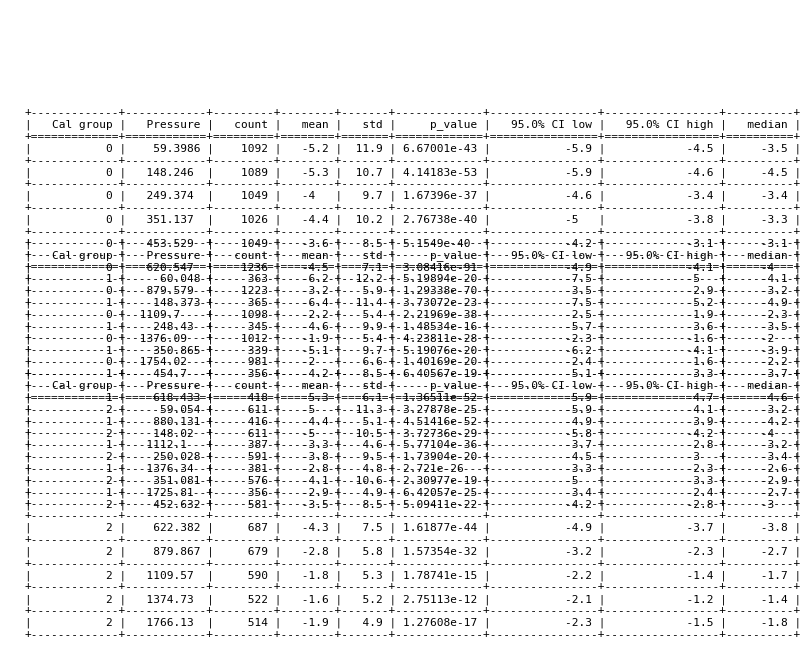

In [331]:
# Filter out rows with nan values in the first element
o2_offset_data_table = [row for row in o2_offset_data_table if not np.isnan(row[1])]
sorted_data_table = sorted(o2_offset_data_table, key=lambda x: x[0])

# base_value = 1
# increment = 3
# num_iterations = 10  # You can adjust this based on the number of iterations you need

# for idx in range(num_iterations):
#     current_value = base_value + increment * idx
#     print(f"Index: {idx}, Value: {current_value}")

for idx, cal in enumerate(cal_groups):
    filtered_data_table = [row for row in sorted_data_table if row[0] == idx]
    # print(cal)
    # print(tabulate(filtered_data_table, headers=['Cal group', 'Pressure', 'count', 'mean', 'std', 'p_value', str(CI_level*100) + '% CI low', str(CI_level*100) + '% CI high', 'median', 'min', 'max'], tablefmt='grid'))
    # Create a string buffer to store the table
    table_buffer = StringIO()

    # Convert the o2_offset_data_table to a table and write it to the buffer
    print(tabulate(filtered_data_table, headers=['Cal group', 'Pressure', 'count', 'mean', 'std', 'p_value', str(CI_level*100) + '% CI low', str(CI_level*100) + '% CI high', 'median'], tablefmt='grid'), file=table_buffer)

    # Display the table in a subplot
    plt.subplot(len(cal_groups),3,(1+3*idx))
    plt.axis('off')  # Turn off axis for the table
    plt.text(0.1, 0.1, table_buffer.getvalue(), va='top', ha='left', fontfamily='monospace', fontsize=8)
    # break

Index: 0, Value: 1
Index: 1, Value: 4
Index: 2, Value: 7
Index: 3, Value: 10
Index: 4, Value: 13
Index: 5, Value: 16
Index: 6, Value: 19
Index: 7, Value: 22
Index: 8, Value: 25
Index: 9, Value: 28


In [13]:
mean_gdap_offsets[filename]['level_0']

<xarray.Dataset>
Dimensions:                           (main_float_wmo: 1322)
Coordinates:
  * main_float_wmo                    (main_float_wmo) int64 1900722 ... 7901028
Data variables: (12/58)
    p_compare_min                     (main_float_wmo) float64 400.0 ... 400.0
    p_compare_max                     (main_float_wmo) float64 2.1e+03 ... 2....
    delta_dens                        (main_float_wmo) float64 0.005 ... 0.005
    delta_spice                       (main_float_wmo) float64 0.005 ... 0.005
    delta_press                       (main_float_wmo) float64 100.0 ... 100.0
    dist                              (main_float_wmo) float64 100.0 ... 100.0
    ...                                ...
    pH_sensor                         (main_float_wmo) object 'none' ... 'SUN...
    nitrate_group                     (main_float_wmo) object 'no nitrate' .....
    nitrate_sensor                    (main_float_wmo) object 'none' ... 'SUN...
    DOXY_group                        (main_float_wmo) object 'DOXY' ... 'DOXY'
    DOXY_sensor                       (main_float_wmo) object 'AANDERAA_OPTOD...
    ice_group                         (main_float_wmo) object 'no ice' ... 'n...

In [252]:
print(big_projects)

['                                                                ', 'ARGO Italy                                                      ', 'ARGO Norway                                                     ', 'Argo Australia', 'Argo Australia                                                  ', 'Argo Canada                                                     ', 'Argo INDIA                                                      ', 'Argo equivalent                                                 ', 'AtlantOS                                                        ', 'CHINA ARGO EQUIVALENT                                           ', 'CORIOLIS                                                        ', 'CORIOLIS_OVIDE                                                  ', 'GMMC OVIDE                                                      ', 'GMMC_CNES                                                       ', 'GO-BGC, WHOI                                                    ', 'IFM-GEOMAR                  

In [243]:
grouped_data = dataset_n.groupby('project_name')

# Get the group names and the counts of data within each group
group_names = grouped_data.groups.keys()
# group_counts = grouped_data.size()

# Display the group names and counts
for group_name, count in zip(group_names, group_counts):
    print(f"Group Name: {group_name}, Count: {count}")

AttributeError: 'DatasetGroupBy' object has no attribute 'size'

In [228]:
for cal_group, group_data in o2_offset_data_table.groupby('Cal group'):
    sorted_data = group_data.sort_values(by='Cal group')  # Sort by 'Cal group' column
    print(tabulate(sorted_data, headers=['Cal group', 'Pressure', 'count', 'mean', 'std', 'p_value', str(CI_level*100) + '% CI low', str(CI_level*100) + '% CI high', 'median', 'min', 'max'], tablefmt='grid'))



AttributeError: 'list' object has no attribute 'groupby'

In [235]:
o2_offset_data_table = [row for row in o2_offset_data_table if not np.isnan(row[1])]

print(o2_offset_data_table)


[(0, <xarray.DataArray 'PRES_ADJUSTED_float' ()>
array(59.39858257), <xarray.DataArray 'DOXY_ADJUSTED_offset_trimmed' ()>
array(1092), <xarray.DataArray 'DOXY_ADJUSTED_offset_trimmed' ()>
array(-5.2), <xarray.DataArray 'DOXY_ADJUSTED_offset_trimmed' ()>
array(11.9), 6.670009390917223e-43, -5.9, -4.5, <xarray.DataArray 'DOXY_ADJUSTED_offset_trimmed' ()>
array(-3.5)), (1, 60.04803358757682, 363, -6.2, 12.2, 5.198944592076658e-20, -7.5, -5.0, -4.1), (2, 60.04803358757682, 363, -6.2, 12.2, 5.198944592076658e-20, -7.5, -5.0, -4.1), (0, <xarray.DataArray 'PRES_ADJUSTED_float' ()>
array(148.24590744), <xarray.DataArray 'DOXY_ADJUSTED_offset_trimmed' ()>
array(1089), <xarray.DataArray 'DOXY_ADJUSTED_offset_trimmed' ()>
array(-5.3), <xarray.DataArray 'DOXY_ADJUSTED_offset_trimmed' ()>
array(10.7), 4.141828089338084e-53, -5.9, -4.6, <xarray.DataArray 'DOXY_ADJUSTED_offset_trimmed' ()>
array(-4.5)), (1, 148.37346879019643, 365, -6.4, 11.4, 3.730719108011515e-23, -7.5, -5.2, -4.9), (2, 148.3734687

In [263]:
# Filter out rows with nan values in the first element
o2_offset_data_table = [row for row in o2_offset_data_table if not np.isnan(row[1])]
sorted_data_table = sorted(o2_offset_data_table, key=lambda x: x[0])

for idx, cal in enumerate(cal_groups):
    filtered_data_table = [row for row in sorted_data_table if row[0] == idx]
    print(cal)
    print(tabulate(filtered_data_table, headers=['Cal group', 'Pressure', 'count', 'mean', 'std', 'p_value', str(CI_level*100) + '% CI low', str(CI_level*100) + '% CI high', 'median', 'min', 'max'], tablefmt='grid'))



                                                                
+-------------+------------+---------+--------+-------+-------------+----------------+-----------------+----------+
|   Cal group |   Pressure |   count |   mean |   std |     p_value |   95.0% CI low |   95.0% CI high |   median |
+=============+============+=========+========+=======+=============+================+=================+==========+
|           0 |    59.3986 |    1092 |   -5.2 |  11.9 | 6.67001e-43 |           -5.9 |            -4.5 |     -3.5 |
+-------------+------------+---------+--------+-------+-------------+----------------+-----------------+----------+
|           0 |   148.246  |    1089 |   -5.3 |  10.7 | 4.14183e-53 |           -5.9 |            -4.6 |     -4.5 |
+-------------+------------+---------+--------+-------+-------------+----------------+-----------------+----------+
|           0 |   249.374  |    1049 |   -4   |   9.7 | 1.67396e-37 |           -4.6 |            -3.4 |     -3.4 |
+------

/Users/smb-uh/opt/anaconda3/envs/float_bgc_synthesis_products/lib/python3.9/site-packages/tabulate/__init__.py:827: UserWarning: Warning: converting a masked element to nan.
  conv(string)
/Users/smb-uh/opt/anaconda3/envs/float_bgc_synthesis_products/lib/python3.9/site-packages/tabulate/__init__.py:1232: UserWarning: Warning: converting a masked element to nan.
  return format(float(val), floatfmt)


In [230]:
row

NameError: name 'row' is not defined

In [66]:
# now for one dataset you have glodap_offsets_mean saved for each pressure level - need to do for all datasets 
trimmed_means['level_200']

<xarray.Dataset>
Dimensions:                           (main_float_wmo: 8)
Coordinates:
  * main_float_wmo                    (main_float_wmo) int64 1901154 ... 5906312
Data variables: (12/58)
    p_compare_min                     (main_float_wmo) float64 1.0 1.0 ... 1.0
    p_compare_max                     (main_float_wmo) float64 550.0 ... 550.0
    delta_dens                        (main_float_wmo) float64 0.1 0.1 ... 0.1
    delta_spice                       (main_float_wmo) float64 0.1 0.1 ... 0.1
    delta_press                       (main_float_wmo) float64 50.0 ... 50.0
    dist                              (main_float_wmo) float64 100.0 ... 100.0
    ...                                ...
    pH_sensor                         (main_float_wmo) object 'none' ... 'ISU...
    nitrate_group                     (main_float_wmo) object 'no nitrate' .....
    nitrate_sensor                    (main_float_wmo) object 'none' ... 'ISU...
    DOXY_group                        (main_float_wmo) object 'DOXY' ... 'DOXY'
    DOXY_sensor                       (main_float_wmo) object 'AANDERAA_OPTOD...
    ice_group                         (main_float_wmo) object 'no ice' ... 'n...